In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
import json
import seaborn as sns
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping

In [2]:
BASE_PATH = './dataset'

In [3]:
def load_view_data(view_name):
    view_name = view_name.upper()

    view_base_path = f'{BASE_PATH}/{view_name}'
    print(f"Processing {view_name} data...")

    metadata = pd.read_csv(f'{view_base_path}/FileList.csv')
    volume_tracings = pd.read_csv(f'{view_base_path}/VolumeTracings.csv')

    video_features = np.load(f'{view_base_path}/video_features.npy', mmap_mode='r').astype('float16')
    ef_values = np.load(f'{view_base_path}/ef_values.npy')

    return metadata, volume_tracings, video_features, ef_values

In [4]:
def process_volume_tracings(volume_tracings):
    volume_features = volume_tracings.groupby('FileName').agg({
        'X': ['mean', 'std', 'min', 'max'],
        'Y': ['mean', 'std', 'min', 'max']
    }).reset_index()

    volume_features.columns = ['_'.join(col).strip() for col in volume_features.columns.values]

    return volume_features

In [42]:
def process_data(metadata, view_name):
    features = metadata.copy()
    features['BMI'] = features['Weight'] / ((features['Height'] / 100) ** 2)
    
    AGE_BINS = [0, 30, 45, 60, 75, float('inf')]
    AGE_CATEGORIES = ['Young', 'Middle-Age', 'Early-Senior', 'Senior', 'Elderly']
    
    # Calculate age encodings for all patients
    age_encodings = []
    for age in features['Age']:
        age_idx = next(i for i, threshold in enumerate(AGE_BINS[1:])
                      if age <= threshold)
        age_encoding = [1 if i == age_idx else 0 for i in range(len(AGE_CATEGORIES))]
        age_encodings.append(age_encoding)
    
    features['BSA'] = 0.007184 * (features['Weight'] ** 0.425) * (features['Height'] ** 0.725)
    features['Ideal_Weight'] = 22 * ((features['Height'] / 100) ** 2)
    features['Weight_Ratio'] = features['Weight'] / features['Ideal_Weight']
    features['Age_Risk'] = features['Age'] / 100
    features['BMI_Risk'] = (features['BMI'] - 25).clip(0) / 10
    
    view_value = 1 if view_name == "A4C" else 0
    
    numerical_features = [
        'Age',
        'Weight',
        'Height',
        'BMI',
        'BSA',
        'Weight_Ratio',
        'Age_Risk',
        'BMI_Risk'
    ]
    
    demographic_features = np.hstack([
        features[numerical_features].values,
        age_encodings,
        np.full((len(features), 1), view_value)
    ])
    
    return demographic_features[:len(features)]

In [26]:
def load_and_combine_views(views=['a4c', 'psax']):
    views = [view.upper() for view in views]

    combined_video = []
    combined_demographic = []
    combined_ef = []

    for view in views:
        if view == 'A4C':
            a4c_metadata, a4c_tracings, a4c_video_features, a4c_ef_values = load_view_data('A4C')
            demographic_features = process_data(a4c_metadata, 'A4C')

            combined_video.append(a4c_video_features)
            combined_demographic.append(demographic_features)
            combined_ef.append(a4c_ef_values)

        elif view == 'PSAX':
            psax_metadata, psax_tracings, psax_video_features, psax_ef_values = load_view_data('PSAX')
            demographic_features = process_data(psax_metadata, 'PSAX')

            combined_video.append(psax_video_features)
            combined_demographic.append(demographic_features[:len(psax_video_features)])
            combined_ef.append(psax_ef_values)

        else:
            raise ValueError(f"Unsupported view type: {view}. Supported views are 'A4C' and 'PSAX'.")

    combined_video = np.vstack(combined_video)
    combined_demographic = np.vstack(combined_demographic)
    combined_ef = np.concatenate(combined_ef)

    print("\nCombined data shapes:")
    print(f"Video features: {combined_video.shape}")
    print(f"Demographic features: {combined_demographic.shape}")
    print(f"EF values: {combined_ef.shape}")

    return combined_video, combined_demographic, combined_ef

In [7]:
def create_model(video_shape, demographic_shape):
    view_input = Input(shape=video_shape)
    view_flattened = TimeDistributed(Flatten())(view_input)
    view_lstm = LSTM(256, return_sequences=True)(view_flattened)
    view_lstm = Dropout(0.5)(view_lstm)
    view_lstm = LSTM(128)(view_lstm)
    view_lstm = Dropout(0.5)(view_lstm)

    view_demographic_input = Input(shape=(demographic_shape,))
    view_demographic_dense = Dense(64, activation='relu')(view_demographic_input)

    view_combined = Concatenate()([view_lstm, view_demographic_dense])

    final_combined = Dense(128, activation='relu')(view_combined)
    final_combined = Dense(64, activation='relu')(final_combined)
    output = Dense(1, activation='linear')(final_combined)

    model = Model(inputs=[view_input, view_demographic_input], outputs=output)

    return model

In [8]:
class TrainingMetricsTracker:
    def __init__(self, model_name):
        self.metrics = {
            'model_metadata': {
                'model_name': model_name,
                'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            },
            'epoch_metrics': [],
            'learning_dynamics': {
                'loss_values': [],
                'mae_values': []
            },
            'performance_breakdown': {
                'per_epoch_performance': {},
                'view_specific_metrics': {}
            },
            'batch_metrics': []
        }
        
        self.output_dir = f'./model_tracking_{model_name}'
        os.makedirs(self.output_dir, exist_ok=True)

    def track_epoch_metrics(self, epoch, logs):
        epoch_metrics = {
            'epoch': epoch,
            'train_loss': logs.get('loss', 0),
            'val_loss': logs.get('val_loss', 0),
            'train_mae': logs.get('mae', 0),
            'val_mae': logs.get('val_mae', 0)
        }
        
        self.metrics['epoch_metrics'].append(epoch_metrics)
        
        self.metrics['learning_dynamics']['loss_values'].append(epoch_metrics['train_loss'])
        self.metrics['learning_dynamics']['mae_values'].append(epoch_metrics['train_mae'])

    def track_view_specific_performance(self, view_name, performance_metrics):
        self.metrics['performance_breakdown']['view_specific_metrics'][view_name] = performance_metrics

    def save_metrics(self):
        metrics_path = os.path.join(self.output_dir, 'training_metrics.json')
        with open(metrics_path, 'w') as f:
            json.dump(self.metrics, f, indent=4)
        
        self._plot_loss_curves()
        self._plot_learning_dynamics()
        self._plot_view_performance()

    def _plot_loss_curves(self):
        df = pd.DataFrame(self.metrics['epoch_metrics'])
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(df['epoch'], df['train_loss'], label='Training Loss')
        plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(df['epoch'], df['train_mae'], label='Training MAE')
        plt.plot(df['epoch'], df['val_mae'], label='Validation MAE')
        plt.title('Mean Absolute Error Curves')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'loss_and_mae_curves.png'))
        plt.close()

    def _plot_learning_dynamics(self):
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.metrics['learning_dynamics']['loss_values'])
        plt.title('Loss Values')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(self.metrics['learning_dynamics']['mae_values'])
        plt.title('Mean Absolute Error')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'learning_dynamics.png'))
        plt.close()

    def _plot_view_performance(self):
        views = list(self.metrics['performance_breakdown']['view_specific_metrics'].keys())
        mae_scores = [
            metrics.get('mae', 0) for metrics in 
            self.metrics['performance_breakdown']['view_specific_metrics'].values()
        ]
        
        plt.figure(figsize=(8, 5))
        plt.bar(views, mae_scores)
        plt.title('Performance by View')
        plt.xlabel('View')
        plt.ylabel('Mean Absolute Error')
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'view_performance.png'))
        plt.close()

def create_tracking_callback(metrics_tracker):    
    class MetricsTrackerCallback(Callback):
        def on_epoch_end(self, epoch, logs=None):
            metrics_tracker.track_epoch_metrics(epoch, logs or {})
        
        def on_train_batch_end(self, batch, logs=None):
            if logs and 'loss' in logs:
                metrics_tracker.metrics['batch_metrics'].append({
                    'batch': batch,
                    'loss': logs.get('loss', 0)
                })
    
    return MetricsTrackerCallback()

In [9]:
def augment_video_data(video_features, augmentation_factor=1.5):
    augmented_features = np.copy(video_features)
    
    noise = np.random.normal(
        0, 
        0.01 * augmentation_factor, 
        augmented_features.shape
    )
    augmented_features += noise
    
    dropout_mask = np.random.random(augmented_features.shape[:2]) > (0.1 * augmentation_factor)
    augmented_features *= dropout_mask[:, :, np.newaxis, np.newaxis, np.newaxis]
    
    return augmented_features

In [46]:
def train_model(views):
    video, demographic, ef = load_and_combine_views(views)
    
    X_video_train, X_video_val, X_demo_train, X_demo_val, y_train, y_val = train_test_split(
        video,
        demographic,
        ef,
        test_size=0.2,
        random_state=42
    )
    
    video_shape = video.shape[1:]
    demographic_shape = demographic.shape[1]
    model = create_model(video_shape, demographic_shape)

    model_name = f"EF_Predictor_{'_'.join(views)}"
    metrics_tracker = TrainingMetricsTracker(model_name)
    tracking_callback = create_tracking_callback(metrics_tracker)
    
    lr_scheduler = LearningRateScheduler(
        lambda epoch: 1e-4 * (0.5 ** np.floor((1+epoch)/5))
    )
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    history = model.fit(
        [X_video_train, X_demo_train],
        y_train,
        validation_data=([X_video_val, X_demo_val], y_val),
        epochs=12,
        batch_size=8,
        callbacks=[
            lr_scheduler,
            tracking_callback
        ]
    )

    metrics_tracker.track_view_specific_performance('Combined', {
        'mae': np.mean(history.history['val_mae']),
        'loss': np.mean(history.history['val_loss'])
    })

    metrics_tracker.save_metrics()
    
    return model, history, metrics_tracker

In [34]:
def evaluate(model_path, view_to_evaluate):
    print(f"\n\nEvaluation For {view_to_evaluate} Starting..\n")
    
    metadata, tracings, video_features, ef_values = load_view_data(view_to_evaluate)

    demographic = process_data(
        metadata, view_to_evaluate
    )
    
    X_train, X_val, X_demo_train, X_demo_val, y_train, y_val = train_test_split(
        video_features,
        demographic[:len(video_features)],
        ef_values,
        test_size=0.2,
        random_state=42
    )
    
    loaded_model = load_model(model_path)
    print("Input data shape:", X_demo_val.shape)
    print("Model's expected input shape:", loaded_model.input_shape)
    
    y_pred = loaded_model.predict([X_val, X_demo_val])

    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2) Score:", r2)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_pred)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
    plt.xlabel("Actual Ejection Fraction")
    plt.ylabel("Predicted Ejection Fraction")
    plt.title("Actual vs Predicted Ejection Fraction")
    plt.show()

    print(f"\n\nEvaluation For {view_to_evaluate} Ended.")

In [12]:
def main(view_to_train):
    model, history, metrics_tracker = train_model([view_to_train])

    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    model_filename = f"{view_to_train}_model_{timestamp}.keras"
    model.save(model_filename)
    return model_filename

Processing A4C data...

Combined data shapes:
Video features: (3284, 30, 7, 7, 512)
Demographic features: (3284, 12)
EF values: (3284,)
Epoch 1/12


C:\Users\Putrajaya-PC09\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_99', 'keras_tensor_105']. Received: the structure of inputs=('*', '*')
  warnings.warn(


329/329 ━━━━━━━━━━━━━━━━━━━━ 202s 600ms/step - loss: 2362.5481 - mae: 44.7351 - val_loss: 115.6728 - val_mae: 7.2134 - learning_rate: 1.0000e-04
Epoch 2/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 194s 590ms/step - loss: 144.7953 - mae: 8.6485 - val_loss: 116.8366 - val_mae: 6.8349 - learning_rate: 1.0000e-04
Epoch 3/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 195s 591ms/step - loss: 127.3452 - mae: 8.1401 - val_loss: 113.5989 - val_mae: 7.5208 - learning_rate: 1.0000e-04
Epoch 4/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 194s 590ms/step - loss: 131.9116 - mae: 8.2944 - val_loss: 114.3520 - val_mae: 6.6682 - learning_rate: 1.0000e-04
Epoch 5/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 194s 591ms/step - loss: 126.9550 - mae: 8.1826 - val_loss: 93.7313 - val_mae: 6.2155 - learning_rate: 5.0000e-05
Epoch 6/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 194s 591ms/step - loss: 106.4613 - mae: 7.6314 - val_loss: 72.9471 - val_mae: 5.7495 - learning_rate: 5.0000e-05
Epoch 7/12
329/329 ━━━━━━━━━━━━━━━━━━━━ 194s 591ms/step - loss: 88.3672 - mae: 7.0614 -

C:\Users\Putrajaya-PC09\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_111', 'keras_tensor_117']. Received: the structure of inputs=('*', '*')
  warnings.warn(


315/315 ━━━━━━━━━━━━━━━━━━━━ 195s 602ms/step - loss: 1877.9780 - mae: 39.7507 - val_loss: 141.6125 - val_mae: 8.1947 - learning_rate: 1.0000e-04
Epoch 2/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 187s 593ms/step - loss: 159.3335 - mae: 9.2270 - val_loss: 142.1257 - val_mae: 8.0467 - learning_rate: 1.0000e-04
Epoch 3/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 187s 593ms/step - loss: 151.6743 - mae: 8.9450 - val_loss: 141.9222 - val_mae: 7.7363 - learning_rate: 1.0000e-04
Epoch 4/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 203s 594ms/step - loss: 143.3266 - mae: 8.7324 - val_loss: 134.1346 - val_mae: 7.5241 - learning_rate: 1.0000e-04
Epoch 5/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 188s 596ms/step - loss: 113.9911 - mae: 7.9387 - val_loss: 83.7312 - val_mae: 6.3707 - learning_rate: 5.0000e-05
Epoch 6/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 187s 595ms/step - loss: 86.9434 - mae: 7.1848 - val_loss: 89.2229 - val_mae: 6.5124 - learning_rate: 5.0000e-05
Epoch 7/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 187s 594ms/step - loss: 82.3766 - mae: 7.0575 - 

C:\Users\Putrajaya-PC09\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_6', 'input_layer_7']. Received: the structure of inputs=('*', '*')
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step
Mean Absolute Error (MAE): 5.854284742636949
Mean Squared Error (MSE): 80.03405815266503
Root Mean Squared Error (RMSE): 8.946175616019676
R-squared (R2) Score: 0.3104391504070575


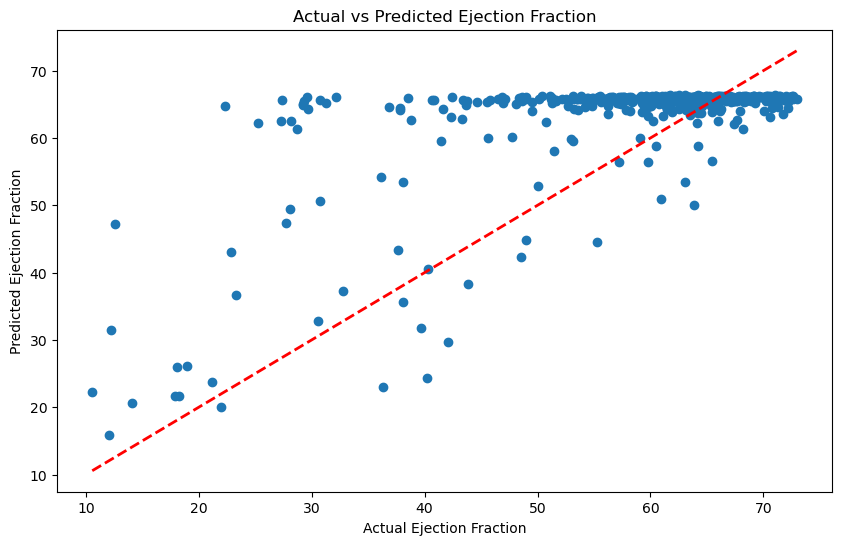



Evaluation For a4c Ended.


Evaluation For psax Starting..

Processing PSAX data...
Input data shape: (629, 12)
Model's expected input shape: [(None, 30, 7, 7, 512), (None, 12)]


C:\Users\Putrajaya-PC09\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_8', 'input_layer_9']. Received: the structure of inputs=('*', '*')
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step
Mean Absolute Error (MAE): 6.441672942824129
Mean Squared Error (MSE): 84.67746701179358
Root Mean Squared Error (RMSE): 9.20203602534752
R-squared (R2) Score: 0.4034869578040907


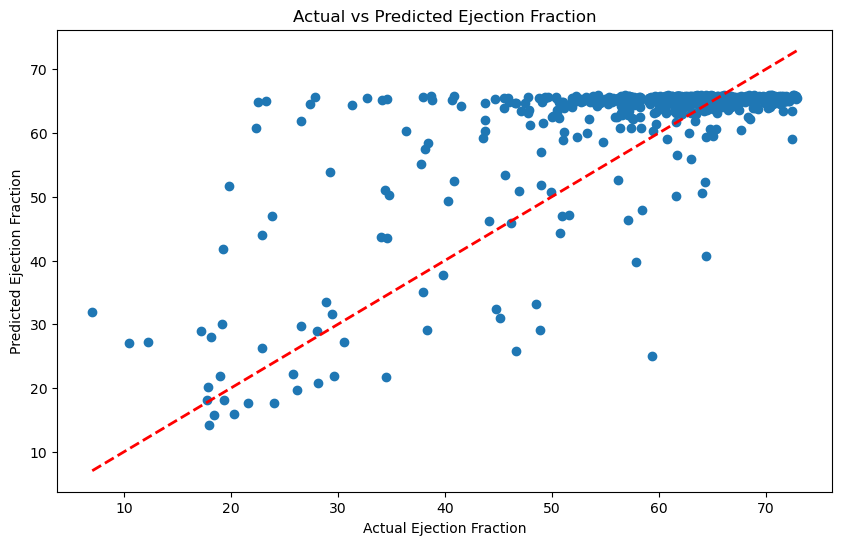



Evaluation For psax Ended.


In [48]:
view_1 = 'a4c'
view_2 = 'psax'
model_1_path = main(view_1)
model_2_path = main(view_2)

evaluate(model_1_path, view_1)
evaluate(model_2_path, view_2)